In [1]:
import os
import time
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

from torchvision import datasets, models, transforms

from torchsummary import summary

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
SEED = 1

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

##**Load dataset**

In [3]:
!gdown 1OJF-F5n83RxIYDC-wX4AUngpdAfbXacN
!unzip cats_and_dogs_large_imbalanced.zip

Streaming output truncated to the last 5000 lines.
  inflating: cats_and_dogs_large/train/dog/dog.8200.jpg  
  inflating: cats_and_dogs_large/train/dog/dog.8201.jpg  
  inflating: cats_and_dogs_large/train/dog/dog.8202.jpg  
  inflating: cats_and_dogs_large/train/dog/dog.8203.jpg  
  inflating: cats_and_dogs_large/train/dog/dog.8204.jpg  
  inflating: cats_and_dogs_large/train/dog/dog.8205.jpg  
  inflating: cats_and_dogs_large/train/dog/dog.8206.jpg  
  inflating: cats_and_dogs_large/train/dog/dog.8207.jpg  
  inflating: cats_and_dogs_large/train/dog/dog.8208.jpg  
  inflating: cats_and_dogs_large/train/dog/dog.8209.jpg  
  inflating: cats_and_dogs_large/train/dog/dog.821.jpg  
  inflating: cats_and_dogs_large/train/dog/dog.8210.jpg  
  inflating: cats_and_dogs_large/train/dog/dog.8211.jpg  
  inflating: cats_and_dogs_large/train/dog/dog.8212.jpg  
  inflating: cats_and_dogs_large/train/dog/dog.8213.jpg  
  inflating: cats_and_dogs_large/train/dog/dog.8214.jpg  
  inflating: cats_and_

##**2. Preprocessing**

In [4]:
transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),   # Resize images to a fixed size
                transforms.ToTensor(),           # Convert images to PyTorch tensors
                transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                     std=(0.5, 0.5, 0.5))
            ])

# Load datasets
train_dataset = datasets.ImageFolder('./cats_and_dogs_large/train', transform=transform)
test_dataset = datasets.ImageFolder('./cats_and_dogs_large/validation', transform=transform)

In [5]:
num_classes = 2

In [6]:
print(f'Numbers of Cat images: {train_dataset.targets.count(0)}')
print(f'Numbers of Dog images: {train_dataset.targets.count(1)}')

Numbers of Cat images: 1000
Numbers of Dog images: 11000


###**Clustering**

In [7]:
idx = 0
dog_train_dataset = []

for i, label in enumerate(train_dataset.targets):
    if label == 1:
        dog_train_dataset.append({
            'data': train_dataset[i],
            'idx': i
        })

In [8]:
len(dog_train_dataset)

11000

In [18]:
dog_train_dataset[0]

{'data': (tensor([[[-0.0824, -0.0980, -0.1608,  ...,  0.0431,  0.0353,  0.0353],
           [-0.0745, -0.0902, -0.1529,  ...,  0.0510,  0.0510,  0.0588],
           [-0.0510, -0.0667, -0.1294,  ...,  0.0667,  0.0588,  0.0667],
           ...,
           [-0.4510, -0.4275, -0.4588,  ..., -0.5137, -0.4510, -0.4118],
           [-0.4510, -0.4353, -0.4353,  ..., -0.4118, -0.4118, -0.4353],
           [-0.4824, -0.4902, -0.4745,  ..., -0.3725, -0.4902, -0.4980]],
  
          [[-0.0980, -0.1137, -0.1843,  ...,  0.0588,  0.0510,  0.0353],
           [-0.0902, -0.1059, -0.1686,  ...,  0.0667,  0.0667,  0.0588],
           [-0.0667, -0.0824, -0.1529,  ...,  0.0824,  0.0745,  0.0667],
           ...,
           [-0.4118, -0.3804, -0.3882,  ..., -0.4431, -0.3725, -0.3333],
           [-0.4118, -0.3961, -0.3647,  ..., -0.3412, -0.3333, -0.3569],
           [-0.4431, -0.4431, -0.4039,  ..., -0.3020, -0.4196, -0.4196]],
  
          [[-0.0118, -0.0118, -0.0667,  ...,  0.1529,  0.1294,  0.0980],
   

In [ ]:
model = models.resnet18(
    weights=models.ResNet18_Weights.IMAGENET1K_V1
)
# remove classifier layer (block)
model = nn.Sequential(
    *list(model.children())[:-1]
)
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [13]:
def predict(preprocess_img):
    # Preprocess image
    preprocess_img = preprocess_img.unsqueeze(0)
    preprocess_img = preprocess_img.to(device)

    # Predict
    with torch.no_grad():
        output = model(preprocess_img)

    return output.squeeze().cpu().numpy()

In [19]:
prediction = predict(dog_train_dataset[0]['data'][0])

In [20]:
prediction

array([2.9566646e+00, 1.3365942e+00, 1.7062795e+00, 1.4710532e+00,
       9.4247693e-01, 1.1533388e+00, 1.2057912e+00, 1.0056957e+00,
       1.6874459e+00, 2.7073715e+00, 5.5644453e-01, 1.3968462e+00,
       8.4788099e-02, 5.7742344e-03, 7.1094386e-02, 1.2867687e+00,
       9.3879449e-01, 1.7650351e-01, 0.0000000e+00, 1.6251868e+00,
       1.5178807e+00, 1.9132345e+00, 1.6401452e-01, 1.7328198e+00,
       1.5703693e-01, 1.5789607e+00, 4.2541495e-01, 2.0738893e+00,
       1.1809726e-01, 5.0033325e-01, 5.5817437e-01, 0.0000000e+00,
       1.1264584e+00, 4.5353040e-01, 1.6351432e+00, 2.9012277e+00,
       1.6066805e+00, 1.8583100e-01, 4.7743127e-01, 1.7015897e-01,
       7.0648509e-01, 2.0302389e+00, 2.0789531e-01, 2.1933820e+00,
       1.2053419e+00, 1.9085243e-01, 1.4307095e-01, 4.0173097e+00,
       5.2896982e-01, 4.8095737e+00, 9.4931215e-01, 0.0000000e+00,
       7.0768487e-01, 8.9975998e-02, 5.6845093e-01, 3.6038451e+00,
       4.8620647e-01, 3.2563944e+00, 1.1043912e+00, 9.5900249e

In [23]:
from tqdm import tqdm

features = []
for input in tqdm(dog_train_dataset):
    prediction = predict(input['data'][0])
    features.append(prediction)

100%|██████████| 11000/11000 [00:33<00:00, 330.50it/s]


In [24]:
from sklearn.cluster import KMeans

n_clusters = 1000
kmean_model = KMeans(n_clusters=n_clusters, n_init='auto')
kmean_model.fit(features)

KMeans(n_clusters=1000, n_init='auto')

In [25]:
kmean_model.cluster_centers_.shape

(1000, 512)

In [26]:
from sklearn.metrics import pairwise_distances_argmin_min

closest, _ = pairwise_distances_argmin_min(kmean_model.cluster_centers_, features, metric="cosine")

In [28]:
closest[0]

235

In [29]:
dog_train_dataset[235]

{'data': (tensor([[[-0.5608, -0.5608, -0.5686,  ..., -0.1843, -0.1686, -0.1608],
           [-0.5529, -0.5608, -0.5686,  ..., -0.1843, -0.1686, -0.1608],
           [-0.5373, -0.5451, -0.5529,  ..., -0.1843, -0.1686, -0.1608],
           ...,
           [-0.6078, -0.6078, -0.5922,  ...,  0.0824,  0.0824,  0.0745],
           [-0.6078, -0.6078, -0.5922,  ...,  0.0667,  0.0667,  0.0667],
           [-0.6078, -0.6078, -0.5922,  ...,  0.0588,  0.0588,  0.0588]],
  
          [[-0.5216, -0.5216, -0.5294,  ..., -0.1137, -0.0980, -0.0902],
           [-0.5137, -0.5216, -0.5294,  ..., -0.1137, -0.0980, -0.0902],
           [-0.4980, -0.5059, -0.5137,  ..., -0.1137, -0.0980, -0.0902],
           ...,
           [-0.5686, -0.5686, -0.5529,  ...,  0.0431,  0.0431,  0.0353],
           [-0.5686, -0.5686, -0.5529,  ...,  0.0275,  0.0275,  0.0275],
           [-0.5686, -0.5686, -0.5529,  ...,  0.0196,  0.0196,  0.0196]],
  
          [[-0.5686, -0.5686, -0.5765,  ..., -0.0588, -0.0431, -0.0353],
   

In [30]:
keep_dog_idxs = []
for i in closest:
    idx = dog_train_dataset[i]['idx']
    keep_dog_idxs.append(idx)

In [32]:
keep_dog_idxs[:5]

[1235, 3051, 5628, 7171, 10854]

In [33]:
cat_idxs = [i for i, label in enumerate(train_dataset.targets) if label == 0]

In [35]:
balanced_indices = cat_idxs + keep_dog_idxs

In [36]:
len(balanced_indices)

2000

In [37]:
# Modify the original dataset's samples and targets to reflect the balanced dataset
train_dataset.samples = [train_dataset.samples[i] for i in balanced_indices]
train_dataset.targets = [train_dataset.targets[i] for i in balanced_indices]

In [38]:
from torch.utils.data import DataLoader

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [39]:
inputs, labels = next(iter(train_loader))

In [40]:
inputs.shape

torch.Size([64, 3, 224, 224])

In [41]:
len(train_loader)

32

##**Trainer**

In [42]:
from sklearn.metrics import classification_report

target_names = ["Cat", "Dog"]

def cls_report(running_target, running_preds, target_names):
    targets = np.hstack(running_target[:-1])
    targets = np.concatenate((targets, running_target[-1]))

    predicts =  np.hstack(running_preds[:-1])
    predicts = np.concatenate((predicts, running_preds[-1]))

    report = classification_report(targets, predicts,
                                   target_names=target_names,
                                   zero_division=0.0, output_dict=True)
    del report['weighted avg']
    return report

In [43]:
def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=25):
    model.train()
    accs, losses = [], []
    start_time = time.time()
    running_target = []
    running_pred = []
    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        running_target.append(labels.cpu().numpy())

        optimizer.zero_grad()

        predictions = model(inputs)
        _, pred = torch.max(predictions, 1)
        running_pred.append(pred.cpu().numpy())

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()

        total_acc = (predictions.argmax(1) == labels).sum().item()
        acc = total_acc / labels.size(0)
        accs.append(acc)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), sum(accs) / len(accs)
                )
            )
            start_time = time.time()

    epoch_acc = sum(accs) / len(accs)
    epoch_loss = sum(losses) / len(losses)
    rp = cls_report(running_target, running_pred, target_names)
    return epoch_acc, epoch_loss, rp

In [45]:
def evaluate_epoch(model, criterion, valid_dataloader):
    model.eval()
    accs, losses = [], []
    running_target = []
    running_pred = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            running_target.append(labels.cpu().numpy())

            predictions = model(inputs)
            _, pred = torch.max(predictions, 1)
            running_pred.append(pred.cpu().numpy())

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc = (predictions.argmax(1) == labels).sum().item()
            acc = total_acc / labels.size(0)
            accs.append(acc)

    epoch_acc = sum(accs) / len(accs)
    epoch_loss = sum(losses) / len(losses)
    rp = cls_report(running_target, running_pred, target_names)
    return epoch_acc, epoch_loss, rp

In [44]:
def train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device):
    train_accs, train_losses = [], []
    eval_accs, eval_losses = [], []
    best_loss_eval = 100
    times = []
    for epoch in range(1, num_epochs+1):
        epoch_start_time = time.time()
        # Training
        train_acc, train_loss, train_rp = train_epoch(model, optimizer, criterion, train_dataloader, device, epoch)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        # Evaluation
        eval_acc, eval_loss, val_rp = evaluate_epoch(model, criterion, valid_dataloader)
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)

        # Save best model
        if eval_loss < best_loss_eval:
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')

        times.append(time.time() - epoch_start_time)

        # Print loss, acc end epoch
        print("=" * 59)
        print(f"Epoch [{epoch}/{num_epochs}]")

        print(f"Train | loss: {train_loss:.4f}, accuracy: {train_acc:.4f}, accuracy_rp: {train_rp['accuracy']:.4f}")
        print(f"\tAvg | precision: {train_rp['macro avg']['precision']:.4f}, recall: {train_rp['macro avg']['recall']:.4f}, F1: {train_rp['macro avg']['f1-score']:.4f}")
        print(f"\tCat | precision: {train_rp['Cat']['precision']:.4f}, recall: {train_rp['Cat']['recall']:.4f}, F1: {train_rp['Cat']['f1-score']:.4f}")
        print(f"\tDog | precision: {train_rp['Cat']['precision']:.4f}, recall: {train_rp['Cat']['recall']:.4f}, F1: {train_rp['Cat']['f1-score']:.4f}")

        print(f"Valid | loss: {eval_loss:.4f}, accuracy: {eval_acc:.4f}, accuracy_rp: {val_rp['accuracy']:.4f}")
        print(f"\tAvg | precision: {val_rp['macro avg']['precision']:.4f}, recall: {val_rp['macro avg']['recall']:.4f}, F1: {val_rp['macro avg']['f1-score']:.4f}")
        print(f"\tCat | precision: {val_rp['Cat']['precision']:.4f}, recall: {val_rp['Cat']['recall']:.4f}, F1: {val_rp['Cat']['f1-score']:.4f}")
        print(f"\tDog | precision: {val_rp['Cat']['precision']:.4f}, recall: {val_rp['Cat']['recall']:.4f}, F1: {val_rp['Cat']['f1-score']:.4f}")
        print("=" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))
    model.eval()
    metrics = {
        'train_accuracy': train_accs,
        'train_loss': train_losses,
        'valid_accuracy': eval_accs,
        'valid_loss': eval_losses,
        'time': times
    }
    return model, metrics

In [46]:
def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

##**Model**

In [47]:
model = models.resnet18(weights=None)

In [48]:
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

In [49]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [51]:
from torchsummary import summary
model.to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [52]:
predictions = model(inputs.to(device))

In [53]:
predictions.shape

torch.Size([64, 2])

In [54]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [55]:
base_model = models.resnet18(weights=None)
in_features = base_model.fc.in_features
base_model.fc = nn.Linear(in_features, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(base_model.parameters(), lr=0.0001)

num_epochs = 50
save_model = './model'
os.makedirs(save_model, exist_ok = True)
model_name = 'base_model'

base_model, base_metrics = train(
    base_model, model_name, save_model, optimizer, criterion, train_loader, test_loader, num_epochs, device
)

| epoch   1 |    25/   32 batches | accuracy    0.591
Epoch [1/50]
Train | loss: 0.6733, accuracy: 0.5908, accuracy_rp: 0.5975
	Avg | precision: 0.5990, recall: 0.5975, F1: 0.5959
	Cat | precision: 0.5867, recall: 0.6600, F1: 0.6212
	Dog | precision: 0.5867, recall: 0.6600, F1: 0.6212
Valid | loss: 1.0068, accuracy: 0.5000, accuracy_rp: 0.5013
	Avg | precision: 0.6253, recall: 0.5013, F1: 0.3375
	Cat | precision: 0.5007, recall: 0.9987, F1: 0.6670
	Dog | precision: 0.5007, recall: 0.9987, F1: 0.6670
| epoch   2 |    25/   32 batches | accuracy    0.716
Epoch [2/50]
Train | loss: 0.5358, accuracy: 0.7368, accuracy_rp: 0.7320
	Avg | precision: 0.7320, recall: 0.7320, F1: 0.7320
	Cat | precision: 0.7311, recall: 0.7340, F1: 0.7325
	Dog | precision: 0.7311, recall: 0.7340, F1: 0.7325
Valid | loss: 0.6419, accuracy: 0.6652, accuracy_rp: 0.6653
	Avg | precision: 0.6664, recall: 0.6653, F1: 0.6648
	Cat | precision: 0.6531, recall: 0.7053, F1: 0.6782
	Dog | precision: 0.6531, recall: 0.7053, F

In [56]:
test_acc, test_loss, rp = evaluate_epoch(base_model, criterion, test_loader)
test_acc, test_loss, rp

(0.6108472644376899,
 2.5386868913439993,
 {'Cat': {'precision': 0.7989130434782609,
   'recall': 0.294,
   'f1-score': 0.4298245614035088,
   'support': 1500},
  'Dog': {'precision': 0.5674019607843137,
   'recall': 0.926,
   'f1-score': 0.7036474164133738,
   'support': 1500},
  'accuracy': 0.61,
  'macro avg': {'precision': 0.6831575021312872,
   'recall': 0.61,
   'f1-score': 0.5667359889084413,
   'support': 3000}})

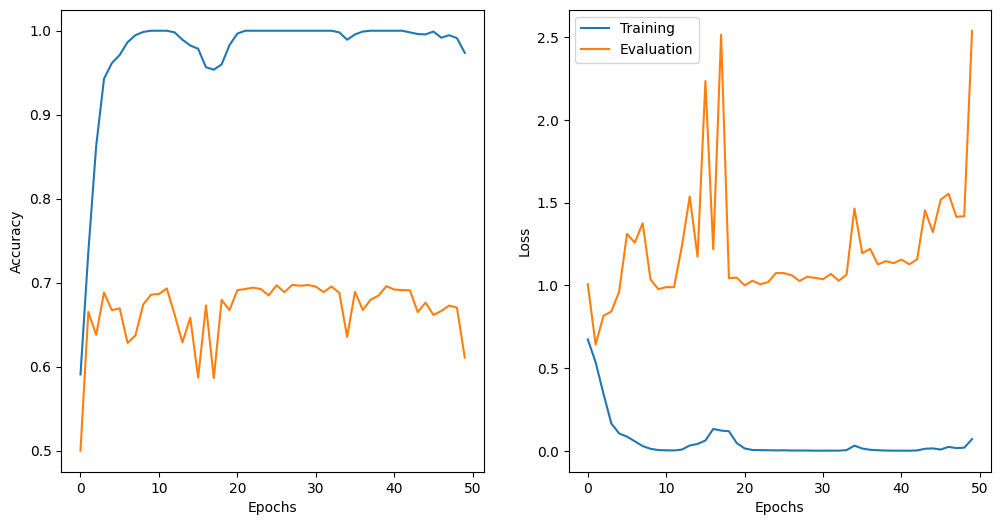

In [57]:
plot_result(
    num_epochs,
    base_metrics["train_accuracy"],
    base_metrics["valid_accuracy"],
    base_metrics["train_loss"],
    base_metrics["valid_loss"]
)